ADO (Automated Data Operations) classification graph for "bad exposure" and "credential expired" 

In [3]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_community.llms import Ollama



In [4]:
llm = Ollama(model="llama3")

C:\Users\svish\AppData\Local\Temp\ipykernel_13380\2786610211.py:1: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model="llama3")


In [5]:
class IssueState(TypedDict):
    issue: str
    classification: Literal["bad_exposure", "credential_expired", "unknown"]
    response: str
    summary: str

In [7]:
# llm classification
def classify_issue(state: IssueState) -> IssueState:
    issue = state["issue"]
    print("Classifying issue using LLM...")
    prompt = f"Classify this IT issue: '{issue}'. Choose from: bad_exposure, credential_expired, unknown."
    result = llm.invoke(prompt)
    classification = "unknown"
    if "bad exposure" in result.lower():
        classification = "bad_exposure"
    elif "credential" in result.lower() or "expired" in result.lower():
        classification = "credential_expired"

    state["classification"] = classification
    return state

In [9]:
# handlers
def handle_bad_exposure(state: IssueState) -> IssueState:
    print("→ Handling bad exposure issue.")
    state["response"] = "This appears to be a bad exposure issue. Please report to IT Security."
    return state

def handle_credential_expired(state: IssueState) -> IssueState:
    print("→ Handling credential expired issue.")
    state["response"] = "Detected expired credentials. Resetting your password now..."
    return state

def handle_unknown(state: IssueState) -> IssueState:
    print("→ Unknown issue. Forwarding to manual IT team.")
    state["response"] = "Unable to classify the issue. Sending to IT team for review."
    return state

def summarize_issue(state: IssueState) -> IssueState:
    print("→ Summarizing issue using LLM.")
    summary = llm.invoke(f"Summarize this IT issue for reporting: {state['issue']}")
    state["summary"] = summary
    return state


In [10]:
# routing function
def route_issue(state: IssueState) -> str:
    return state["classification"]


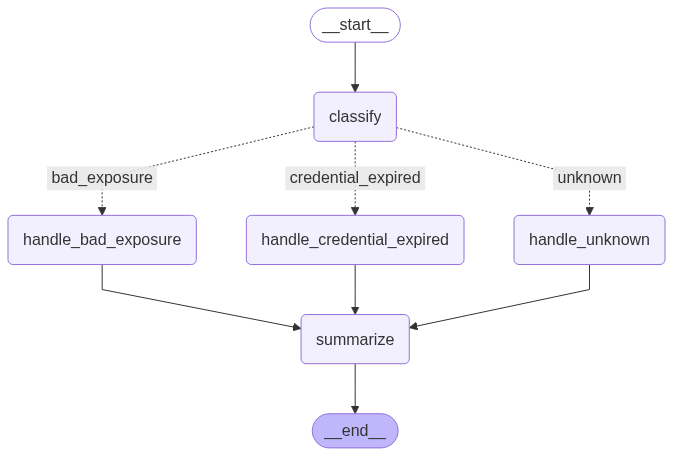

In [17]:
builder = StateGraph(IssueState)

# Add Nodes (Steps)
builder.add_node("classify", RunnableLambda(classify_issue))
builder.add_node("handle_bad_exposure", RunnableLambda(handle_bad_exposure))
builder.add_node("handle_credential_expired", RunnableLambda(handle_credential_expired))
builder.add_node("handle_unknown", RunnableLambda(handle_unknown))
builder.add_node("summarize", RunnableLambda(summarize_issue))

# Set Entry Point
builder.set_entry_point("classify")

# Route After Classification
builder.add_conditional_edges("classify", route_issue, {
    "bad_exposure": "handle_bad_exposure",
    "credential_expired": "handle_credential_expired",
    "unknown": "handle_unknown"
})

# After handling any issue → summarization
builder.add_edge("handle_bad_exposure", "summarize")
builder.add_edge("handle_credential_expired", "summarize")
builder.add_edge("handle_unknown", "summarize")

# End after summarization
builder.add_edge("summarize", END)

# Compile the graph
graph = builder.compile()
builder.compile()

In [ ]:
inputs = [
    {"issue": "My ADO is not working. Seems like credential expired."},
    {"issue": "There is a bad exposure in my ADO configuration."},
    {"issue": "I'm facing overheating issue with ADO."}
]

for input_data in inputs:
    print("\n==============================")
    result = graph.invoke(input_data)
    print("Final Output:", result)



Classifying issue using LLM...
→ Handling credential expired issue.
→ Summarizing issue using LLM.
Final Output: {'issue': 'My ADO is not working. Seems like credential expired.', 'classification': 'credential_expired', 'response': 'Detected expired credentials. Resetting your password now...', 'summary': "Here's a summary of the IT issue:\n\n**Issue:** Active Directory Object (ADO) not functioning.\n\n**Symptom:** Credential appears to have expired, preventing ADO from working as expected.\n\nPlease provide more details or context if needed!"}

Classifying issue using LLM...
→ Handling bad exposure issue.
→ Summarizing issue using LLM.
Final Output: {'issue': 'There is a bad exposure in my ADO configuration.', 'classification': 'bad_exposure', 'response': 'This appears to be a bad exposure issue. Please report to IT Security.', 'summary': "Here's a summary of the IT issue for reporting:\n\n**Issue:** Malicious Exposure in ADO Configuration\n\n**Description:** A vulnerability has been

NameError: name 'visualize' is not defined